In [ ]:
!pip3 install pandas
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install numpy
!pip3 install sklearn
#!pip3 install haversine
!pip3 install xgboost

# **Импортируем библиотеки**

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn as sk
#from haversine import haversine
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

# **Читаем датасет. Экономим время и работаем с первой десяткой тысяч результатов**

In [37]:
test = pd.read_csv('test.csv', nrows=1e6)
train = pd.read_csv('df.csv', nrows=1e6)

# **Приводим в порядок данные**

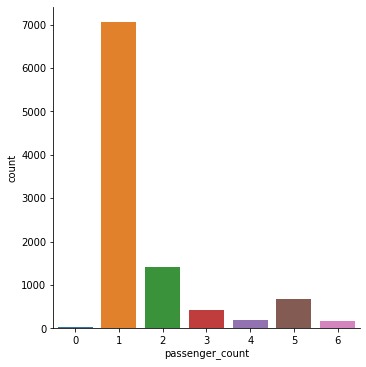

In [38]:
passenger_count = train['passenger_count']
sns.catplot(x=passenger_count, kind='count', data=train)

**На графике видно, что количество пассажиров находится в диапазоне от 1 до 6. В дальнейшем, мы отсеим фантомные поездки (где количество пассажиров меньше 1).**


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


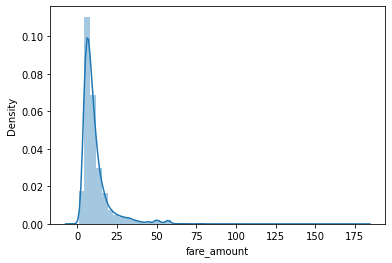

In [39]:
sns.distplot(train['fare_amount'])

**Также, мы можем заметить, что поездки в основном стоили до ~$80. Критические значения, а так же отрицательные, мы уберём**

Пишем функцию, которая уберёт пустые значение, столбец ключей, переведёт pickup_datetime из object в datetime формат, добавит столбцы часов дня, дней недели, месяца и года, а также столбец с дистанцией поездки. Функцию, вычисляющую эту дистанцию разберём ниже.

In [40]:
def data_cleanup(df):
    df.dropna(inplace=True)
    df.drop(columns='key', inplace=True, errors='ignore')
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')
    df = df[df['passenger_count'].between(1, 6)]
    if 'fare_amount' in df.columns:
      df = df[df['fare_amount'].between(1, 80)]
    df['hour'] = df.pickup_datetime.dt.hour
    df['weekday'] = df.pickup_datetime.dt.weekday
    df['month'] = df.pickup_datetime.dt.month
    df['year'] = df.pickup_datetime.dt.year
    df['distance'] = round(haversine(df['pickup_longitude'], df['pickup_latitude'], 
                                     df['dropoff_longitude'], df['dropoff_latitude']), ndigits=2)
    return df

# **Пишем функцию вычисления дистанции поездки**

Функция берёт точку подбора и доставки клиента, и через формулу Хаверсина вычисляет приблизительную дистанцию.

In [41]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    newlon = lon2 - lon1
    newlat = lat2 - lat1
    haversine_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
    dist = 2 * np.arcsin(np.sqrt(haversine_formula))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

# **Смотрим на обработанный датасет**

In [42]:
data_cleanup(train)
data_cleanup(test)

train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


# **Готовим данные для обучения**

In [43]:
f_train = train.drop(columns=['pickup_datetime'], axis= 1).copy()
df_test = test.drop(columns=['pickup_datetime'], axis= 1).copy()

X_train, X_test, y_train, y_test = train_test_split(df_train.drop('fare_amount', axis=1),
                                                    df_train['fare_amount'], test_size=0.3, random_state = 38)

# **Задаём параметры алгоритму**

Задача заключается в предсказывании значений стоимости поездки. Для такой задачи подойдёт алгоритм экстремального градиентного бустинга.

In [44]:
params = {
    'max_depth': 7,
    'gamma' :0,
    'eta':.03, 
    'subsample': 1,
    'colsample_bytree': 0.9, 
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 0
}

def XGBmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train,num_boost_round=5000, 
                    early_stopping_rounds=10,evals=[(matrix_test,'test')])
    return model

model = XGBmodel(X_train,X_test,y_train,y_test,params)

[15:56:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:13.2315
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:12.8833
[2]	test-rmse:12.5431
[3]	test-rmse:12.2174
[4]	test-rmse:11.9029
[5]	test-rmse:11.5982
[6]	test-rmse:11.3046
[7]	test-rmse:11.018
[8]	test-rmse:10.7444
[9]	test-rmse:10.4763
[10]	test-rmse:10.2174
[11]	test-rmse:9.97105
[12]	test-rmse:9.72837
[13]	test-rmse:9.50628
[14]	test-rmse:9.28058
[15]	test-rmse:9.06391
[16]	test-rmse:8.8532
[17]	test-rmse:8.65432
[18]	test-rmse:8.46373
[19]	test-rmse:8.27458
[20]	test-rmse:8.09696
[21]	test-rmse:7.92408
[22]	test-rmse:7.76125
[23]	test-rmse:7.60403
[24]	test-rmse:7.45106
[25]	test-rmse:7.30452
[26]	test-rmse:7.15973
[27]	test-rmse:7.02452
[28]	test-rmse:6.89457
[29]	test-rmse:6.76863
[30]	test-rmse:6.65192
[31]	test-rmse:6.53505
[32]	test-rmse:6.42521
[33]	test-rmse:6.31703
[34]	test-rmse:6.21937
[35]	test-rmse:6.12475
